### Dynamic programming, efficient, discrete.

#### Translated from Eva Carceles-Poveda's MATLAB codes

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline 

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

In [2]:
# Parameters
alpha = 0.33
beta = 0.9
sigma = 2
delta = 0.1
PAR = np.array([alpha,beta,sigma,delta])

#print(PAR)

In [3]:
# Shock
SSS = np.array([0.9,1.1])
TM = np.array([[0.8, 0.2],[0.2, 0.8]])

#print(SSS)
#print(TM)

In [4]:
# Steady State
kb = (1 / beta / alpha + (delta - 1) / alpha)**(1 / (alpha - 1))
ib = delta * kb
cb = kb**alpha - ib

DSS = np.array([kb,cb,ib])

#print(DSS)

In [5]:
# Capital grid
NK = 200
kmax = 1.5*kb
nk = NK
kminmax = np.array([0.5*kb,kmax]) # kminmax is a two elements vector with the min and max of capital
Kgrid = np.linspace(kminmax[0],kminmax[1],nk)

#print(Kgrid)

In [6]:
# utility function
def fu(x, gamma):
    if gamma != 1:
        y = x**(1 - gamma)/(1 - gamma)
    else:
        y = np.log(x)
    
    return y


# production function
def fprod(x, alpha):
    y = x**alpha
    return y


In [7]:
# This is used to calculate the excution time of the while loop
import time

def dpnew(ir, Kgrid, PAR, DSS, SSS, TM):
    """ Syntax: [vnew, gk] = dpnew(ir, Kgrid, PAR, DSS, SSS, TM)

    ir is 0 or 1, where 0 refers to the default option of reversible investment
    kgrid is the capital grid
    PAR is the parameter vector, DSS is the deterministic steady state
    SSS is the state space of shock, TM is the transition matrix
    """
    


    beta = PAR[1]
    delta = PAR[3]

    cb = DSS[1]

    sss = SSS
    tm = TM
    ns = sss.size

    kg = Kgrid
    nk = kg.size

    # initial value to be half of deterministic steady state
    vold = np.zeros((nk,ns))
    vnew = 0.5 * fu(cb,PAR[2]) * np.ones((nk,ns)) / (1 - beta)

    gk = np.zeros((nk,ns))
    
    
    #required array of consumption combination, c(k',k,theta), in an
    #nk^2 * ns by 1 form

    # first create an array of investment
    iv = np.kron(np.ones((nk,)), kg) - np.kron((1 - delta) * kg, np.ones((nk,)))
    if ir == 1:
        iv = np.maximum(iv,np.zeros((nk**2,)))
        
    iv = np.kron(np.ones((ns,)),iv)   #nk^2*ns by 1 array
    
    # compute consumption array
    c = np.kron(sss,np.kron(fprod(kg,PAR[0]),np.ones((nk,)))) - iv
    Ic = np.argwhere(c >= 0)  # indices of infeasible consumption
    u = -0.5 * np.finfo(float).max * np.ones((nk**2 * ns,))  # initialize current utility array
    u[Ic] = fu(c[Ic],PAR[2])  # utility level is -inf for infeasible consumption
    u = u.reshape((nk,nk,ns),order="F")  # put u into the required array form

    print("norm = ", np.linalg.norm(vold-vnew,1))
    
    start = time.perf_counter()
    while np.linalg.norm(vold - vnew,1) > 1e-6:
        vold = vnew.copy()
        vful = np.dot(vold, tm)  # vful is in k' by k by theta form
        vful = np.reshape(np.kron(np.ones((nk,)),vful),(nk,nk,ns))
        vnew, gk = (u + beta * vful).max(axis=0), (u + beta * vful).argmax(axis=0)
        print("norm = ", np.linalg.norm(vold-vnew,1))

    stop = time.perf_counter()
    print("Elapsed time in seconds for the while loop is:", round(stop - start,4))
    
    return vnew, gk


In [8]:
v, gk = dpnew(0, Kgrid, PAR, DSS, SSS, TM)
gc=np.dot(SSS[:,np.newaxis],np.ones((1,nk))).T*(np.dot((Kgrid[:,np.newaxis]**alpha),np.ones((1,SSS.size))))\
+(1-delta)*Kgrid[:,np.newaxis]*np.ones((1,SSS.size))-Kgrid[gk]

norm =  951.1881625017182
norm =  37.57152109876606
norm =  82.67138250132354
norm =  87.10225960840418
norm =  82.32977149064968
norm =  75.46242160180486
norm =  68.38493897663302
norm =  61.6720053480926
norm =  55.4956407375535
norm =  49.88559446179087
norm =  44.82231313765797
norm =  40.2659893552341
norm =  36.172410607146716
norm =  32.49726962780982
norm =  29.198911651601467
norm =  26.238973043662128
norm =  23.582423116167163
norm =  21.197759780824555
norm =  19.056766653765674
norm =  17.134126632407103
norm =  15.407216334175956
norm =  13.855719216473915
norm =  12.46166814942846
norm =  11.208741852362392
norm =  10.082569328856446
norm =  9.070089342150785
norm =  8.159751840284521
norm =  7.3411733582902645
norm =  6.605012793984949
norm =  5.942891217005998
norm =  5.347326312006979
norm =  4.811591526270016
norm =  4.32964182269281
norm =  3.8960538587497826
norm =  3.5059562491384817
norm =  3.1549730947659516
norm =  2.8391719664795385
norm =  2.5550145642350035

In [9]:
#print(v)
#print(gk)
#print(gc)

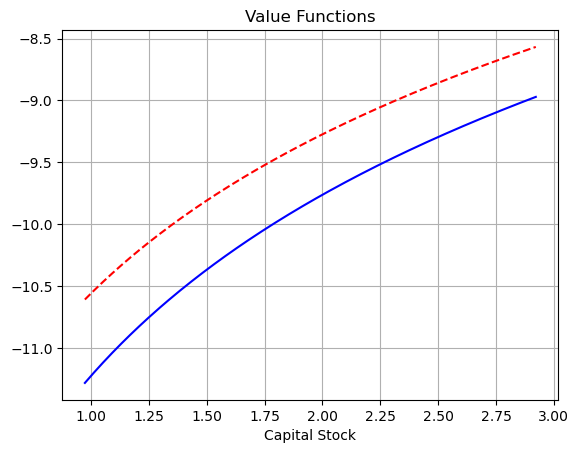

In [10]:
# Make plots of value and policy functions
fig, ax = plt.subplots()
ax.plot(Kgrid, v[:,0], 'b')
ax.plot(Kgrid, v[:,-1], 'r--')

ax.set(xlabel='Capital Stock', title='Value Functions')
ax.grid()

fig.savefig("plot_value.jpg", dpi=800)
plt.show()

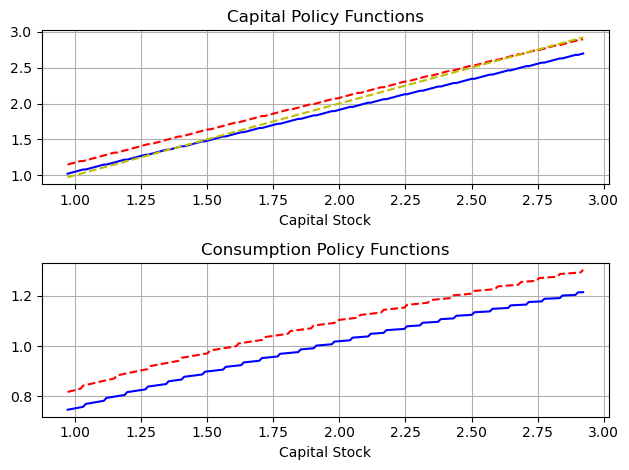

In [11]:
fig2, axs = plt.subplots(2, 1)

axs[0].plot(Kgrid, Kgrid[gk[:,0]], 'b')
axs[0].plot(Kgrid, Kgrid[gk[:,-1]], 'r--')
axs[0].plot(Kgrid, Kgrid, 'y--')
axs[0].set(xlabel='Capital Stock', title='Capital Policy Functions')
axs[0].grid()


axs[1].plot(Kgrid, gc[:,0], 'b')
axs[1].plot(Kgrid, gc[:,-1], 'r--')
axs[1].set(xlabel='Capital Stock', title='Consumption Policy Functions')
axs[1].grid()


plt.tight_layout()
plt.savefig('plot_policy.jpg', dpi=800)
plt.show()
plt.close(fig2)